<a href="https://colab.research.google.com/github/Franklingo13/ejemplosCopernicus/blob/main/ejemplosJupyter/deslizamineto_tierra_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enfoque basado en el NDVI para estudiar áreas de deslizamientos de tierra
Las investigaciones indican que el NDVI puede desempeñar un papel crucial en la identificación de zonas de deslizamientos. Si bien es posible un flujo de trabajo avanzado, este cuaderno opta por un enfoque simple que utiliza la diferencia del NDVI y aplica un umbral al resultado para detectar zonas de deslizamientos. Nuestro análisis se basa en la colección Sentinel-2 Nivel 2A, obtenida del ecosistema de datos de Copernicus mediante openEO.

In [21]:
%pip install openeo rasterio matplotlib numpy

In [4]:
import openeo
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=CHKW-UDQZ 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [18]:
# Area de interés
spatial_extent = {
    "west": -78.375778,
    "south": -0.538524,
    "east": -78.273193,
    "north": -0.449101,
}

# Periodo ANTES del deslizamiento (9 de Julio de 2025).
# Se usa un mes completo para tener más posibilidades de encontrar imágenes sin nubes.
temporal_extent_pre = ["2025-06-01", "2025-07-08"]

# Periodo DESPUÉS del deslizamiento.
temporal_extent_post = ["2025-07-10", "2025-07-31"]

# Cargar la colección de datos Sentinel-2
s2pre = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent_pre,
    spatial_extent=spatial_extent,
    bands=["B04", "B08"],
)
# Calcular el NDVI
prendvi = s2pre.ndvi().mean_time()

# Para el cubo de datos posterior, se carga la colección de datos Sentinel-2 con la extensión
# temporal comenzando desde el final de la extensión temporal previa al evento.
s2post = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent_post,
    spatial_extent=spatial_extent,
    bands=["B04", "B08"],
)

# Calcular el NDVI para el cubo de datos posterior
postndvi = s2post.ndvi().mean_time()
# Calcular la diferencia del NDVI
diff = postndvi - prendvi
# Ejecuta el proceso
diff.download("NDVIDiff.tiff")


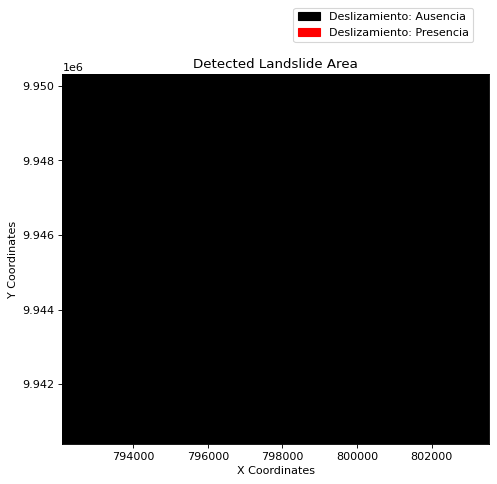

In [19]:
# Graficar el resultado
# Cargar la imagen resultante
img = rasterio.open("NDVIDiff.tiff")

# Se aplica un umbral para resaltar las áreas de deslizamiento
value = img.read(1)
cmap = matplotlib.colors.ListedColormap(["black", "red"])
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
im = show(
    ((value < -0.48) & (value > -1)),
    vmin=0,
    vmax=1,
    cmap=cmap,
    transform=img.transform,
    ax=ax,
)
values = ["Ausencia", "Presencia"]
colors = ["black", "red"]
ax.set_title("Detected Landslide Area")
ax.set_xlabel("X Coordinates")
ax.set_ylabel("Y Coordinates")
patches = [
    mpatches.Patch(color=colors[i], label="Deslizamiento: {l}".format(l=values[i]))
    for i in range(len(values))
]
fig.legend(handles=patches, bbox_to_anchor=(0.83, 1.03), loc=1)

In [26]:
# Paso 5b: Flujo de trabajo para Sentinel-1 (Detección de Cambio con Radar)
print("\n--- Iniciando Flujo de Trabajo para Sentinel-1 (Radar) ---")
# Cargar la colección de datos de Radar Sentinel-1 (GRD)
s1_pre_evento = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=temporal_extent_pre,
    spatial_extent=spatial_extent,
    bands=["VV"] # Usamos la polarización VV, sensible a cambios en la superficie
)
pre_radar = s1_pre_evento.mean_time()

s1_post_evento = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=temporal_extent_post,
    spatial_extent=spatial_extent,
    bands=["VV"]
)
post_radar = s1_post_evento.mean_time()

# Calcular el ratio de cambio. Un cambio significativo (valor > 1) puede indicar un deslizamiento.
# Se suma un valor pequeño para evitar la división por cero.
cambio_radar = post_radar / (pre_radar + 0.0001)

output_file_s1 = "S1_cambio_LaMica.tiff"
cambio_radar.download(output_file_s1)
print(f"Resultado de Sentinel-1 guardado como '{output_file_s1}'")

# Paso 5c: Flujo de trabajo para Sentinel-1 (Visualización Geográfica)
print("\n--- Generando imagen geográfica de Sentinel-1 ---")
# Usaremos la imagen de radar pre-evento para visualizar la geografía base.
# La señal de radar es excelente para resaltar la topografía.
output_file_s1_geo = "S1_geografia_LaMica.tiff"
pre_radar.download(output_file_s1_geo)
print(f"Imagen geográfica de Sentinel-1 guardada como '{output_file_s1_geo}'")


--- Iniciando Flujo de Trabajo para Sentinel-1 (Radar) ---
Resultado de Sentinel-1 guardado como 'S1_cambio_LaMica.tiff'

--- Generando imagen geográfica de Sentinel-1 ---
Imagen geográfica de Sentinel-1 guardada como 'S1_geografia_LaMica.tiff'



--- Visualizando Resultados de Sentinel-1 ---


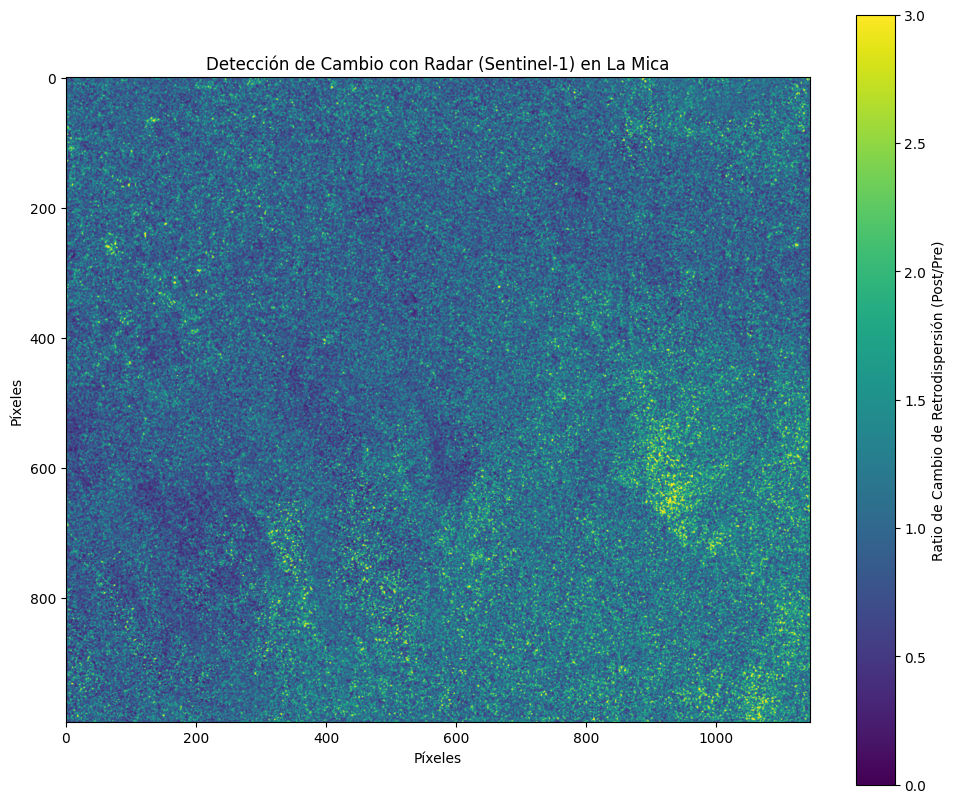

In [27]:
# Paso 7: Visualizar el resultado de Sentinel-1 (Cambio de Radar)
import numpy as np
print("\n--- Visualizando Resultados de Sentinel-1 ---")
try:
    with rasterio.open(output_file_s1) as img:
        value_ratio = img.read(1)

        # Eliminar valores infinitos o no válidos que puedan resultar de la división
        value_ratio[~np.isfinite(value_ratio)] = 1.0

        # --- Graficar el ratio de cambio ---
        fig, ax = plt.subplots(figsize=(12, 10), dpi=100)

        # Usamos un mapa de color que muestre bien las variaciones.
        # vmax=3 significa que estamos interesados en áreas donde la señal de radar se triplicó o más.
        im = ax.imshow(value_ratio, cmap='viridis', vmin=0, vmax=3)

        fig.colorbar(im, ax=ax, label="Ratio de Cambio de Retrodispersión (Post/Pre)")
        ax.set_title("Detección de Cambio con Radar (Sentinel-1) en La Mica")
        ax.set_xlabel("Píxeles")
        ax.set_ylabel("Píxeles")
        plt.show()
except Exception as e:
    print(f"No se pudo procesar el archivo de Sentinel-1: {e}")


--- Visualizando Geografía del Terreno con Sentinel-1 ---


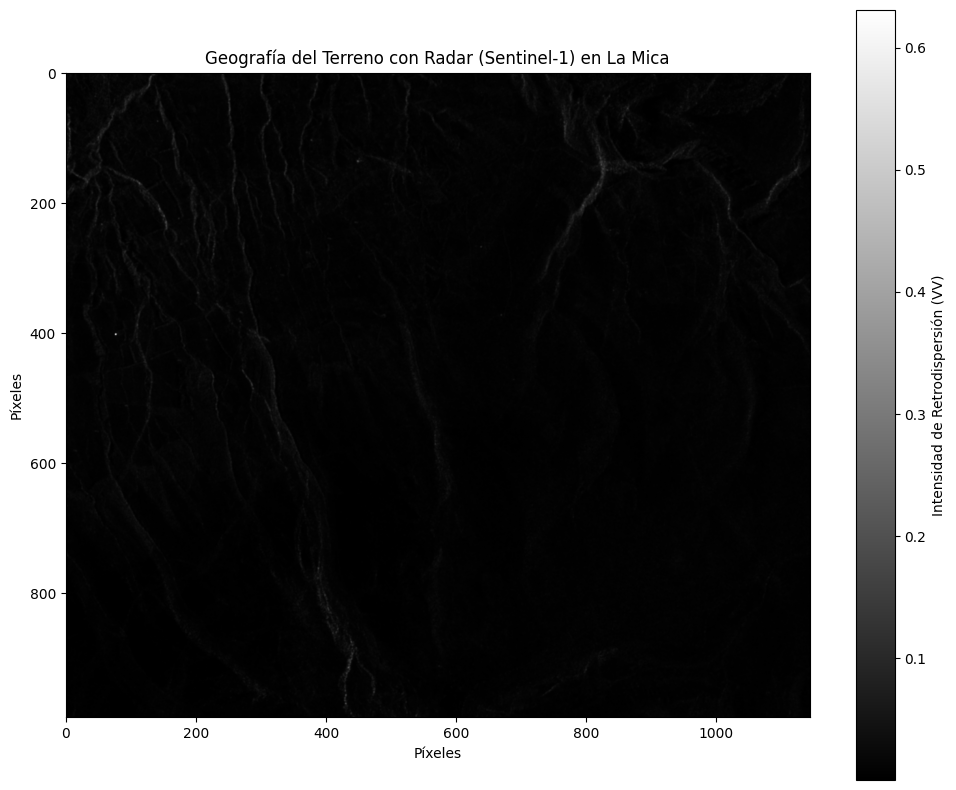

In [28]:
# Paso 8: Visualizar Geografía del Terreno (Radar)
print("\n--- Visualizando Geografía del Terreno con Sentinel-1 ---")
try:
    with rasterio.open(output_file_s1_geo) as img:
        value_geo = img.read(1)

        # --- Graficar la imagen de radar en escala de grises ---
        fig, ax = plt.subplots(figsize=(12, 10), dpi=100)

        # El mapa de color 'gray' es ideal para este tipo de visualización
        im = ax.imshow(value_geo, cmap='gray')

        fig.colorbar(im, ax=ax, label="Intensidad de Retrodispersión (VV)")
        ax.set_title("Geografía del Terreno con Radar (Sentinel-1) en La Mica")
        ax.set_xlabel("Píxeles")
        ax.set_ylabel("Píxeles")
        plt.show()
except Exception as e:
    print(f"No se pudo procesar el archivo geográfico de Sentinel-1: {e}")
